In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    print(dirname)

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input
/kaggle/input/identifying-disease-in-tea-leafs
/kaggle/input/identifying-disease-in-tea-leafs/tea sickness dataset
/kaggle/input/identifying-disease-in-tea-leafs/tea sickness dataset/white spot
/kaggle/input/identifying-disease-in-tea-leafs/tea sickness dataset/Anthracnose
/kaggle/input/identifying-disease-in-tea-leafs/tea sickness dataset/healthy
/kaggle/input/identifying-disease-in-tea-leafs/tea sickness dataset/bird eye spot
/kaggle/input/identifying-disease-in-tea-leafs/tea sickness dataset/brown blight
/kaggle/input/identifying-disease-in-tea-leafs/tea sickness dataset/red leaf spot
/kaggle/input/identifying-disease-in-tea-leafs/tea sickness dataset/gray light
/kaggle/input/identifying-disease-in-tea-leafs/tea sickness dataset/algal leaf


In [2]:
import os

os.environ["KERAS_BACKEND"] = "jax"  # @param ["tensorflow", "jax", "torch"]

import tensorflow as tf
import keras
from keras import layers

import numpy as np
import matplotlib.pyplot as plt

2025-09-13 07:25:27.194251: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1757748327.386175      36 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1757748327.453189      36 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [3]:
path = "/kaggle/input/identifying-disease-in-tea-leafs/tea sickness dataset"

train,test = tf.keras.utils.image_dataset_from_directory(
    path,
    label_mode="categorical",
    validation_split=0.2,
    subset="both",
    seed=42,
    batch_size=32,
    image_size=(768, 768),
)

train=train.cache().prefetch(1).shuffle(100)
test=test.cache().prefetch(1)

Found 885 files belonging to 8 classes.
Using 708 files for training.
Using 177 files for validation.


I0000 00:00:1757748340.311571      36 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 13942 MB memory:  -> device: 0, name: Tesla T4, pci bus id: 0000:00:04.0, compute capability: 7.5
I0000 00:00:1757748340.312265      36 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:1 with 13942 MB memory:  -> device: 1, name: Tesla T4, pci bus id: 0000:00:05.0, compute capability: 7.5


In [4]:
# Convert to numpy arrays
x_train = []
y_train = []
for images, labels in train:
    x_train.append(images.numpy())
    y_train.append(labels.numpy())

x_train = tf.concat(x_train, axis=0).numpy()
y_train = tf.concat(y_train, axis=0).numpy()

x_test = []
y_test = []
for images, labels in test:
    x_test.append(images.numpy())
    y_test.append(labels.numpy())

x_test = tf.concat(x_test, axis=0).numpy()
y_test = tf.concat(y_test, axis=0).numpy()

print("Training set:", x_train.shape, y_train.shape)
print("Test set:", x_test.shape, y_test.shape)


Training set: (708, 768, 768, 3) (708, 8)
Test set: (177, 768, 768, 3) (177, 8)


In [5]:
# Change y labels as class numbers instead of one-hot encoding
y_train_label = []
for y in y_train:
    label = np.argmax(y)
    y_train_label.append(label)

y_train_label = np.array(y_train_label).reshape(y_train.shape[0], 1)

y_test_label = []
for y in y_test:
    label = np.argmax(y)
    y_test_label.append(label)

y_test_label = np.array(y_test_label).reshape(y_test.shape[0], 1)

print(f"x_train shape: {x_train.shape} - y_train shape: {y_train_label.shape}")
print(f"x_test shape: {x_test.shape} - y_test shape: {y_test_label.shape}")

x_train shape: (708, 768, 768, 3) - y_train shape: (708, 1)
x_test shape: (177, 768, 768, 3) - y_test shape: (177, 1)


In [6]:
learning_rate = 0.0003
weight_decay = 0.001
batch_size = 128
num_epochs = 100
image_size = 768
patch_size = 16
num_patches = (image_size // patch_size) ** 2

projection_dim = 128
num_heads = 8

transformer_units = [
    projection_dim * 2,
    projection_dim,
]
transformer_layers = 8
mlp_head_units = [
    1024,
    512,
]

In [7]:
data_augmentation = keras.Sequential(
    [
        layers.Normalization(),
        layers.Resizing(image_size, image_size),
        layers.RandomFlip("horizontal"),
        layers.RandomRotation(factor=0.02),
        layers.RandomZoom(height_factor=0.2, width_factor = 0.2),
        layers.RandomContrast(factor=0.2),
    ],
    name = "data_augmentation"
)

data_augmentation.layers[0].adapt(x_train)

INFO:2025-09-13 07:26:26,279:jax._src.xla_bridge:924: Unable to initialize backend 'rocm': module 'jaxlib.xla_extension' has no attribute 'GpuAllocatorConfig'
INFO:2025-09-13 07:26:26,291:jax._src.xla_bridge:924: Unable to initialize backend 'tpu': INTERNAL: Failed to open libtpu.so: libtpu.so: cannot open shared object file: No such file or directory


### Create MLP

In [8]:
def mlp(x, hidden_units, dropout_rate):
    for units in hidden_units:
        x = layers.Dense(units, activation=keras.activation.gelu)(x)
        x = layers.Dropout(dropout_rate)(x)
    return x

# Patch layer

In [9]:
class patchImage(layers.Layer):
    def __init__(self, patch_size):
        super().__init__()
        self.patch_size = patch_size
    
    def call(self, images):
        size = tf.shape(images)
        batch_size = size[0]
        height, width, channels = size[1], size[2], size[3]
        num_patches_h = height // self.patch_size
        num_patches_w = width // self.patch_size
    
        patches = tf.image.extract_patches(
            images=images,
            sizes=[1, self.patch_size, self.patch_size, 1],
            strides=[1, self.patch_size, self.patch_size, 1],
            rates=[1, 1, 1, 1],
            padding="VALID"
        )
        
        patches = tf.reshape(
            patches,
            (batch_size, num_patches_h * num_patches_w, self.patch_size * self.patch_size * channels)
        )
        
        return patches
    
    def get_config(self):
        config = super().get_config()
        config.update({"patch_size": self.patch_size})
        return config

Image size: 768 x 768
Patch size: 16 x 16
Number of patches: 2304
Elements per patch: 768


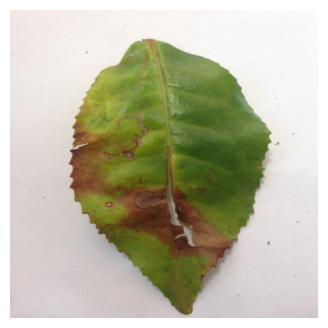

In [10]:
test_image   = x_train[np.random.choice(range(x_train.shape[0]))]

plt.figure(figsize=(4,4))
plt.imshow(test_image.astype("uint8"))
plt.axis("off")

resized_test_image = tf.image.resize(
    tf.convert_to_tensor([test_image]), size=(image_size, image_size)
)

patches = patchImage(patch_size)(resized_test_image)
print(f"Image size: {image_size} x {image_size}")
print(f"Patch size: {patch_size} x {patch_size}")
print(f"Number of patches: {patches.shape[1]}")
print(f"Elements per patch: {patches.shape[-1]}")

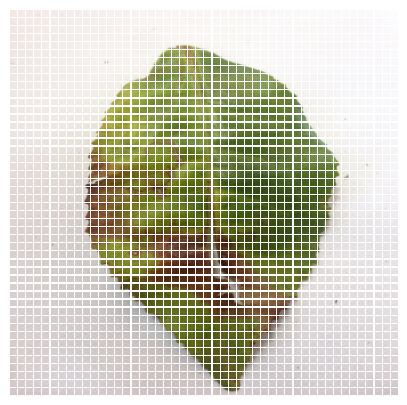

In [11]:
n = int(np.sqrt(patches.shape[1]))
plt.figure(figsize=(5,5))
for i in range(n * n):
    ax = plt.subplot(n, n, i + 1)
    patch = patches[0, i, :]
    patch = tf.reshape(
        patch,
        (patch_size, patch_size, 3)
    )
    plt.imshow(patch.numpy().astype("uint8"))
    plt.axis("off")

# Patch Encoder

In [14]:
class patchEncoder(layers.Layer):
    def __init__(self, num_patches, projection_dim):
        super().__init__()
        self.num_patches = num_patches
        self.projection = layers.Dense(units=projection_dim)
        self.position_embedding = layers.Embedding(input_dim = num_patches,output_dim = projection_dim)
        
    def call(self, patch):
        positions = tf.expand_dims(
             tf.range(start=0, limit=self.num_patches, delta=1), axis=0
         )
        projected_patches = self.projection(patch)
        encoded = projected_patches + self.projection_embedding(positions)
        return encoded
    def get_config(self):
        config = super().get_config()
        config.update({"num_patches": self.num_patches})
        return config   